In [14]:
# import geocoder
# g=geocoder.ip("me")
location = [1.385110, 103.745000]
print(location)

df = pd.read_csv("./Data/1_4_2021_carpark_availability.csv", header=None)
df[5] = df[5].str.split(" ", n=1, expand=False)
latlng = pd.DataFrame(df[5].to_list(), columns=['lat', 'lng'])
latlng.insert(0, 'ID', df[2])
latlng['lat'] = pd.to_numeric(latlng['lat'], errors='coerce')
latlng['lng'] = pd.to_numeric(latlng['lng'], errors='coerce')

radius = 0.005
near_me = pd.DataFrame(latlng[abs(latlng['lat'] - location[0]) < radius])
near_me = pd.DataFrame(near_me[abs(near_me['lng'] - location[1]) < radius])
ID = list(set(near_me["ID"]))
ID

print("There are " +str(len(ID))+" carparks near your location!")

predictCarparkSlots(ID, 1, 15)

[1.38511, 103.745]


C:\Users\yewfy\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


There are 19 carparks near your location!


C:\Users\yewfy\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\yewfy\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


EmptyDataError: No columns to parse from file

In [13]:
#Pandas, Json and formatting stuff
import pandas as pd
from datetime import datetime
import numpy as np

#For file iteration
import os

#For Graphing
import seaborn as sb
import matplotlib.pyplot as plt 
sb.set() 

#linreg
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

#carparkID is a list of strings, weekday is binary 1 for weekday and 0 for weekend, predhr is an int of hour in 24h format
def predictCarparkSlots(carparkIDs, weekday, predhr):
    counter = 0
    #Create Dictionary to store all data
    #Dict key = Date
    carparkInfoDict = {}
    for filename in os.listdir("./Data/"):
        if filename.endswith(".csv"): 
            #print(os.path.join("./Data/", filename))
            path = os.path.join("./Data/", filename)
            formatDate = filename.replace("_carpark_availability.csv", "")
            formatDate = formatDate.replace("_", "/")

            carparkInfoDict[formatDate] = pd.read_csv(path, header=None)
            continue
        else:
            continue
    for i in carparkInfoDict:
        carparkInfoDict[i].columns = ["Time", "Date", "CarParkID","Area","Development", "Location", "AvailableLots", "LotType", "Agency"]
        carparkInfoDict[i]['Time'] = pd.to_timedelta(carparkInfoDict[i]['Time'])
        carparkInfoDict[i]['Time'] = carparkInfoDict[i]['Time'].dt.total_seconds().div(60).astype(int)
        #carparkInfoDict[i]["DateTime"] = pd.to_datetime(carparkInfoDict[i]["Date"] + ' ' + carparkInfoDict[i]["Time"])
        #carparkInfoDict[i].set_index("DateTime")
#         print(i)
#         print(carparkInfoDict[i].head())
    print("It is predicted that there are:")
    for carparkID in carparkIDs:
        #Create a dataframe for the selected carpark id
        lotinfoWD = lotinfoWE = pd.DataFrame()
        for i in carparkInfoDict:
            #for weekdays
            if (weekday == 1 and datetime.strptime(i, '%d/%m/%Y').weekday() < 5):
                #print("weekday "+ i)
                lotinfoWD = lotinfoWD.append(carparkInfoDict[i].query('CarParkID == "%s" and LotType == "C"' %carparkID))
                #lotinfoWD['Time'] = lotinfoWD['Time'].str[:2]
            elif (weekday == 0 and datetime.strptime(i, '%d/%m/%Y').weekday() >= 5):
                #print("weekend "+ i)
                lotinfoWE = lotinfoWE.append(carparkInfoDict[i].query('CarParkID == "%s" and LotType == "C"' %carparkID))
                #lotinfoWE['Time'] = lotinfoWE['Time'].str[:2]
            else: 
                pass

        if (weekday == 1):
            lotinfoWD = lotinfoWD.sort_values(by=['Time'])
            lotinfoWD = lotinfoWD.reset_index()
            lotinfo = lotinfoWD
        else: 
            lotinfoWE = lotinfoWE.sort_values(by=['Time'])
            lotinfoWE = lotinfoWE.reset_index()
            lotinfo = lotinfoWE

        #Visualise data (Optional)
#         f = plt.figure(figsize=(30, 15))
#         plt.scatter(lotinfo['Time']/60, lotinfo['AvailableLots'])
#         #f= plt.yticks(np.arange(round(min(lotinfoWD['AvailableLots']-10)/10)*10, max(lotinfoWD['AvailableLots'])+11, 10))
#         f= plt.xticks(np.arange(min(lotinfo['Time']/60), max(lotinfo['Time']/60)+1, 1))

        #Do polynomial regression

        linreg = LinearRegression()

        y = pd.DataFrame(lotinfo['AvailableLots'])
        x = pd.DataFrame(lotinfo['Time'])
        poly_reg = PolynomialFeatures(degree = 2)
        x_poly = poly_reg.fit_transform(x)
        poly_reg.fit(x_poly, y)
        linreg.fit(x_poly, y)

        #Predict
        predtime = [[predhr*60]]
        pred = pd.DataFrame(predtime , columns = ['Time'])
        pred_poly = poly_reg.fit_transform(pred)
        for i in linreg.predict(pred_poly):
            for j in i:
                j = round(j)
        if (j<0):
            j = 0;
        development = carparkInfoDict["26/3/2021"].loc[carparkInfoDict["26/3/2021"]['CarParkID'] == carparkID].Development.iloc[0]
        counter = counter + 1
        print(str(counter)+". "+str(j)+" carpark slots in "+development) #+" at "+str(predhr)+" 00 HRS!"
        

In [41]:
#carparkID is a list of strings, weekday is binary 1 for weekday and 0 for weekend, predhr is an int of hour in 24h format
carparkIDs = ['3', '56', '59', '66', 'A0011', 'C0133', 'H0024', 'HLM']
predictCarparkSlots(carparkID, 1, 13)

It is predicted that there are 338 carpark slots in Raffles City at 13 00 HRS!
It is predicted that there are 58 carpark slots in National Gallery at 13 00 HRS!
It is predicted that there are 212 carpark slots in Clarke Quay at 13 00 HRS!
It is predicted that there are 169 carpark slots in Funan Mall at 13 00 HRS!
It is predicted that there are 19 carpark slots in ARMENIAN STREET OFF STREET at 13 00 HRS!
It is predicted that there are 3 carpark slots in CARPENTER STREET OFF STREET at 13 00 HRS!
It is predicted that there are 0 carpark slots in HONG LIM PARK OFF STREET at 13 00 HRS!
It is predicted that there are 79 carpark slots in BLK 531A HONG LIM MSCP at 13 00 HRS!


It is predicted that there are 125 carpark slots in BLK 743/751 JURONG WEST STREET 73 at 15 00 HRS!


125

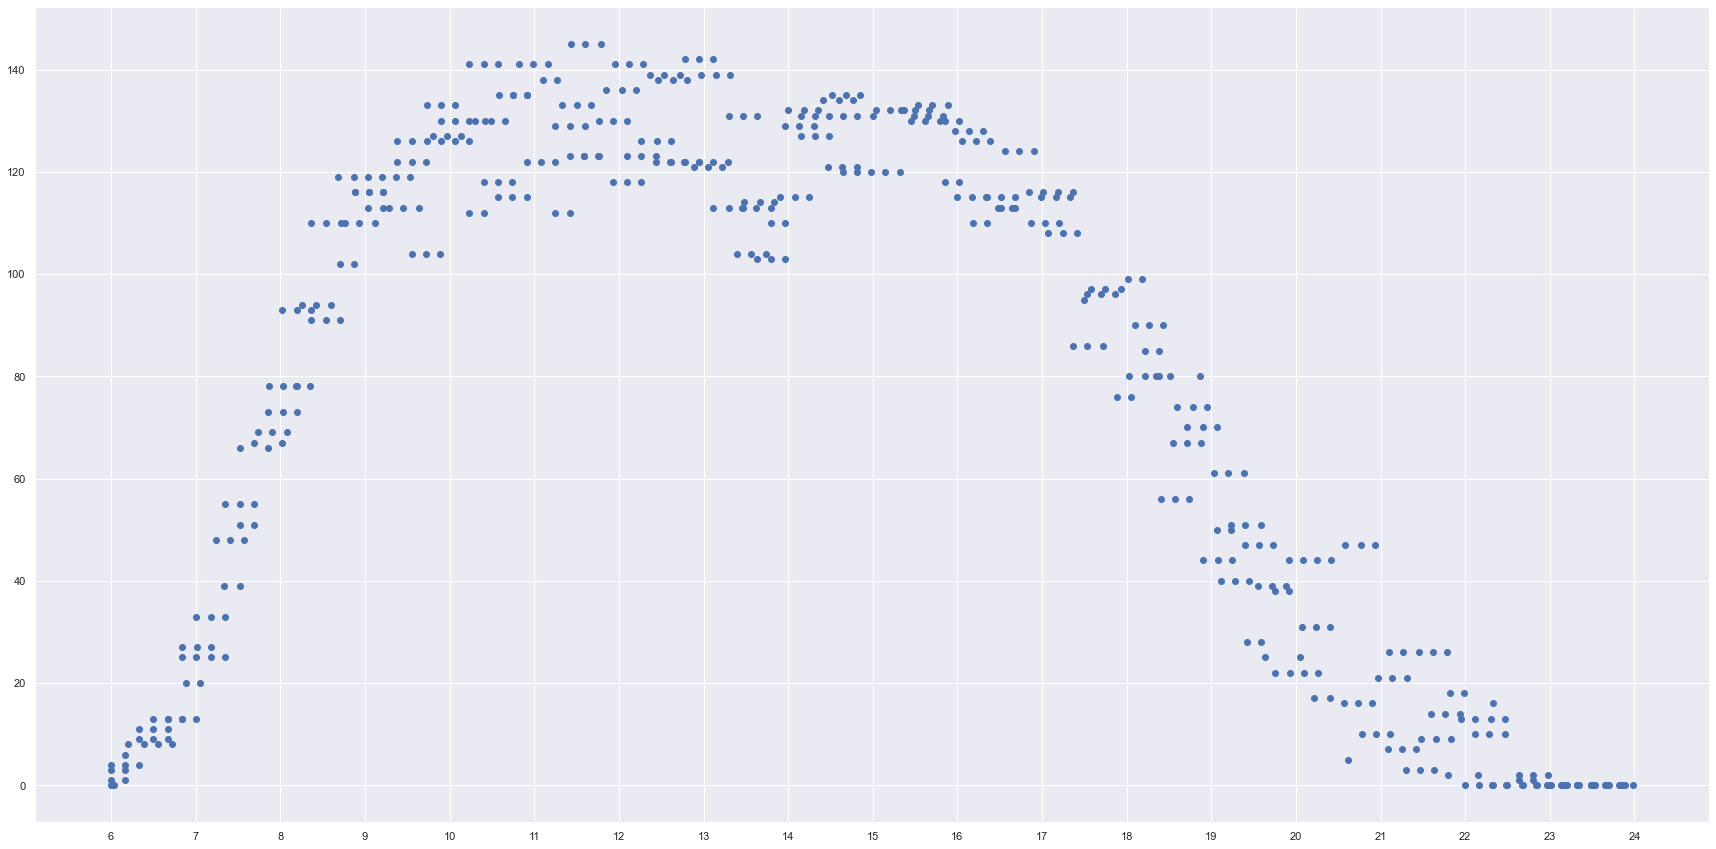

In [85]:
predictCarparkSlots("J72", 1, 15)

In [1]:
#Pandas, Json and formatting stuff
import pandas as pd
import requests
import json
from datetime import datetime
import numpy as np

#GSheets Stuff
import gspread
from df2gspread import df2gspread as d2g
from df2gspread import gspread2df as g2d
from oauth2client.service_account import ServiceAccountCredentials

#For Sleep
import time

#For Graphing
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

In [ ]:
scope = ["https://spreadsheets.google.com/feeds",
        "https://www.googleapis.com/auth/drive"]
credentials = ServiceAccountCredentials.from_json_keyfile_name("./creds.json", scope)
gc = gspread.authorize(credentials)


#spreadsheet_key = '1rbE6gzggvnMVHICgnydxLc1ouIGy63m_G7w16kZ7jFU'
spreadsheet_key = '1VUZEdaKFAAssCLy7VAOkrYhcpTqBGy5MLB72LBK4w2A'
wks_name = 'Sheet1'

df = pd.DataFrame(g2d.download(spreadsheet_key, wks_name, col_names=False, row_names=False, credentials=credentials, start_cell='A1'))


df.head()

In [2]:
carparkInfoDict = {}
carparkInfoDict["26/3/2021"] = pd.read_csv('./Data/26_3_2021_carpark_availability - Sheet1.csv', header=None)
carparkInfoDict["27/3/2021"] = pd.read_csv('./Data/27_3_2021_carpark_availability - Sheet1.csv', header=None)
carparkInfoDict["28/3/2021"] = pd.read_csv('./Data/28_3_2021_carpark_availability - Sheet1.csv', header=None)
carparkInfoDict["29/3/2021"] = pd.read_csv('./Data/29_3_2021_carpark_availability - Sheet1.csv', header=None)
carparkInfoDict["30/3/2021"] = pd.read_csv('./Data/30_3_2021_carpark_availability - Sheet1.csv', header=None)
carparkInfoDict["31/3/2021"] = pd.read_csv('./Data/31_3_2021_carpark_availability - Sheet1.csv', header=None)
carparkInfoDict["1/4/2021"] = pd.read_csv('./Data/1_4_2021_carpark_availability - Sheet1.csv', header=None)
for i in carparkInfoDict:
    carparkInfoDict[i].columns = ["Time", "Date", "CarParkID","Area","Development", "Location", "AvailableLots", "LotType", "Agency"]
    carparkInfoDict[i]['Time'] = pd.to_timedelta(carparkInfoDict[i]['Time'])
    carparkInfoDict[i]['Time'] = carparkInfoDict[i]['Time'].dt.total_seconds().div(60).astype(int)
    #carparkInfoDict[i]["DateTime"] = pd.to_datetime(carparkInfoDict[i]["Date"] + ' ' + carparkInfoDict[i]["Time"])
    #carparkInfoDict[i].set_index("DateTime")
    print(i)
    print(carparkInfoDict[i].head())

26/3/2021
   Time        Date CarParkID    Area         Development           Location  \
0   360  26/03/2021         1  Marina         Suntec City  1.29375 103.85718   
1   360  26/03/2021         2  Marina       Marina Square  1.29115 103.85728   
2   360  26/03/2021         4  Marina       The Esplanade  1.29011 103.85561   
3   360  26/03/2021         5  Marina  Millenia Singapore  1.29251 103.86009   
4   360  26/03/2021         6  Marina     Singapore Flyer  1.28944 103.86311   

   AvailableLots LotType Agency  
0           2845       C    LTA  
1           1894       C    LTA  
2            712       C    LTA  
3           1251       C    LTA  
4            139       C    LTA  
27/3/2021
   Time        Date CarParkID    Area         Development           Location  \
0   360  27/03/2021         1  Marina         Suntec City  1.29375 103.85718   
1   360  27/03/2021         2  Marina       Marina Square  1.29115 103.85728   
2   360  27/03/2021         3  Marina        Raffles Ci

In [3]:
carparkInfoDict["1/4/2021"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150943 entries, 0 to 150942
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Time           150943 non-null  int32 
 1   Date           150943 non-null  object
 2   CarParkID      150943 non-null  object
 3   Area           3167 non-null    object
 4   Development    150943 non-null  object
 5   Location       150943 non-null  object
 6   AvailableLots  150943 non-null  int64 
 7   LotType        150943 non-null  object
 8   Agency         150943 non-null  object
dtypes: int32(1), int64(1), object(7)
memory usage: 9.8+ MB


In [59]:
carparkid = "P5"
weekday = 0
lotinfoWD = lotinfoWE = pd.DataFrame()
for i in carparkInfoDict:
    #for weekdays
    if (weekday == 1 and datetime.strptime(i, '%d/%m/%Y').weekday() < 5):
        #print("weekday "+ i)
        lotinfoWD = lotinfoWD.append(carparkInfoDict[i].query('CarParkID == "%s" and LotType == "C"' %carparkid))
        #lotinfoWD['Time'] = lotinfoWD['Time'].str[:2]
    elif (weekday == 0 and datetime.strptime(i, '%d/%m/%Y').weekday() >= 5):
        #print("weekend "+ i)
        lotinfoWE = lotinfoWE.append(carparkInfoDict[i].query('CarParkID == "%s" and LotType == "C"' %carparkid))
        #lotinfoWE['Time'] = lotinfoWE['Time'].str[:2]
    else: 
        pass

if (weekday == 1):
    lotinfoWD = lotinfoWD.sort_values(by=['Time'])
    lotinfoWD = lotinfoWD.reset_index()
else: 
    lotinfoWE = lotinfoWE.sort_values(by=['Time'])
    lotinfoWE = lotinfoWE.reset_index()

In [7]:
lotinfoWD

,index,Time,Date,CarParkID,Area,Development,Location,AvailableLots,LotType,Agency
0,220,360,26/03/2021,P5,NaN,BLK 107 PUNGGOL FIELD,1.396877555 103.9076419,170,C,HDB
1,220,360,31/03/2021,P5,NaN,BLK 107 PUNGGOL FIELD,1.396877555 103.9076419,165,C,HDB
2,219,360,01/04/2021,P5,NaN,BLK 107 PUNGGOL FIELD,1.396877555 103.9076419,166,C,HDB
3,219,360,29/03/2021,P5,NaN,BLK 107 PUNGGOL FIELD,1.396877555 103.9076419,156,C,HDB
4,220,362,30/03/2021,P5,NaN,BLK 107 PUNGGOL FIELD,1.396877555 103.9076419,164,C,HDB
...,...,...,...,...,...,...,...,...,...,...
457,245572,1429,26/03/2021,P5,NaN,BLK 107 PUNGGOL FIELD,1.396877555 103.9076419,221,C,HDB
458,240809,1430,29/03/2021,P5,NaN,BLK 107 PUNGGOL FIELD,1.396877555 103.9076419,179,C,HDB
459,218860,1431,31/03/2021,P5,NaN,BLK 107 PUNGGOL FIELD,1.396877555 103.9076419,180,C,HDB
460,220374,1433,30/03/2021,P5,NaN,BLK 107 PUNGGOL FIELD,1.396877555 103.9076419,181,C,HDB


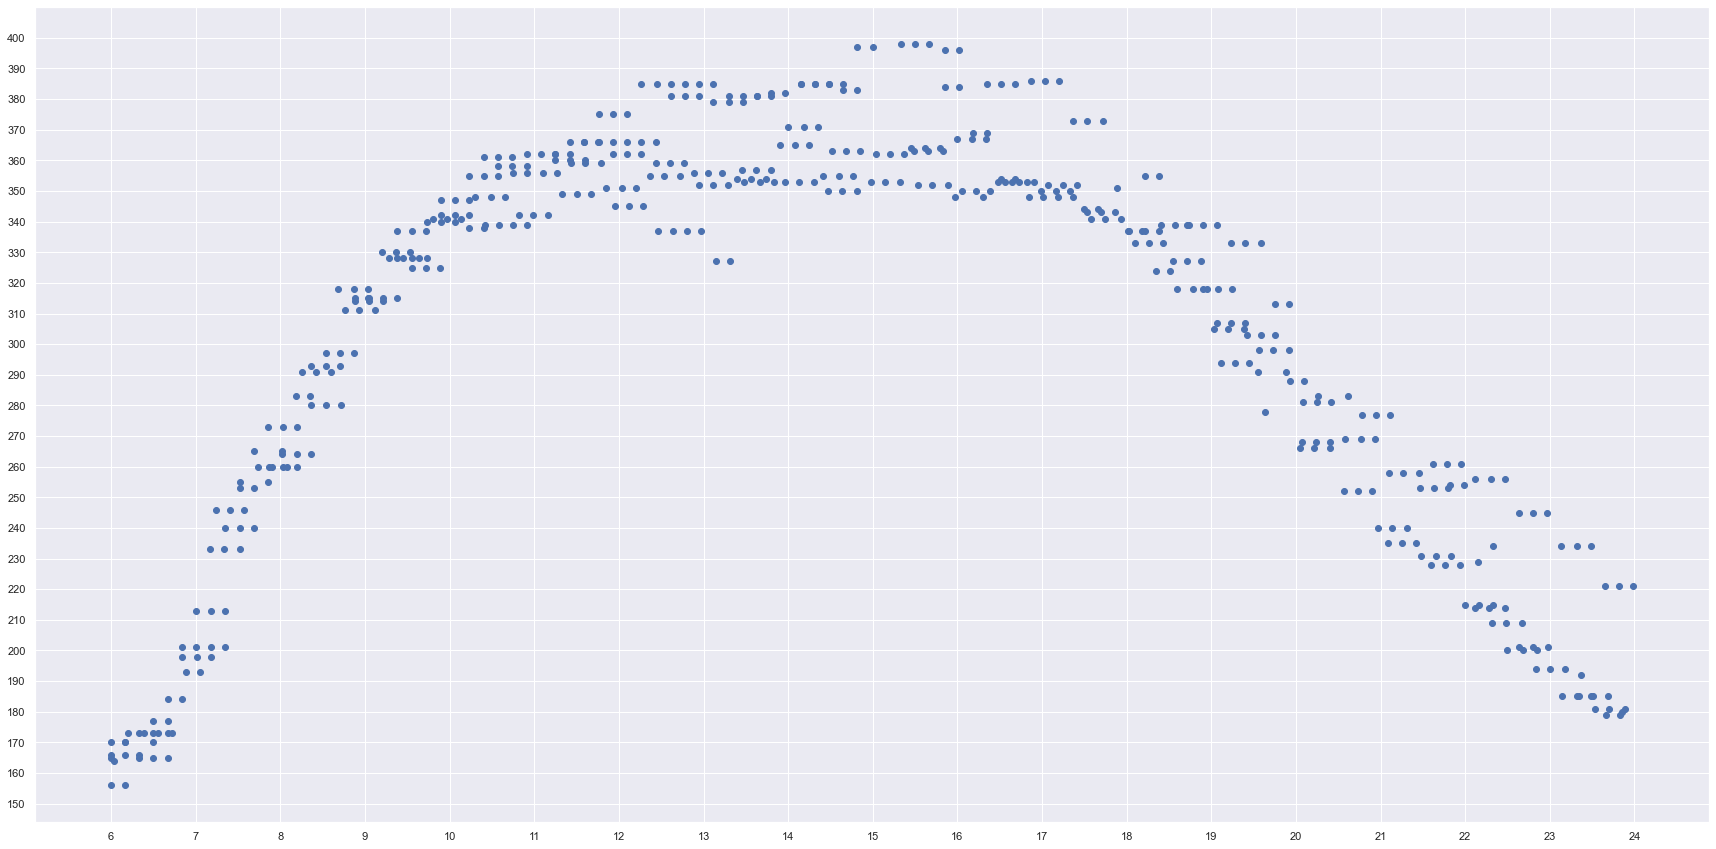

In [19]:
f = plt.figure(figsize=(30, 15))
plt.scatter(lotinfoWD['Time']/60, lotinfoWD['AvailableLots'])
f= plt.yticks(np.arange(round(min(lotinfoWD['AvailableLots']-10)/10)*10, max(lotinfoWD['AvailableLots'])+11, 10))
f= plt.xticks(np.arange(min(lotinfoWD['Time']/60), max(lotinfoWD['Time']/60)+1, 1))

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
linreg = LinearRegression()

y = pd.DataFrame(lotinfoWD['AvailableLots'])
x = pd.DataFrame(lotinfoWD['Time'])
poly_reg = PolynomialFeatures(degree = 2)
x_poly = poly_reg.fit_transform(x)
poly_reg.fit(x_poly, y)
linreg.fit(x_poly, y)
y_pred = linreg.predict(x_poly)
y_pred

# y = pd.DataFrame(lotinfoWD['AvailableLots'])
# x = pd.DataFrame(lotinfoWD['Time'])
# linreg.fit(x, y)
# y_pred = linreg.predict(x)
# x.info()
# f = plt.figure(figsize=(16, 8))

# # plt.plot(regline_x, regline_y, 'r-', linewidth = 3)
# plt.show()

array([[182.2294496 ],
       [182.2294496 ],
       [182.2294496 ],
       [182.2294496 ],
       [183.7098072 ],
       [189.57411125],
       [189.57411125],
       [189.57411125],
       [189.57411125],
       [191.02590567],
       [196.77595699],
       [196.77595699],
       [196.77595699],
       [198.90866162],
       [203.83498684],
       [203.83498684],
       [203.83498684],
       [203.83498684],
       [205.9248467 ],
       [210.7512008 ],
       [210.7512008 ],
       [210.7512008 ],
       [210.7512008 ],
       [212.79821588],
       [217.52459885],
       [217.52459885],
       [217.52459885],
       [219.52876917],
       [224.15518101],
       [224.15518101],
       [224.81038435],
       [226.11650656],
       [230.64294727],
       [231.28386903],
       [231.28386903],
       [231.28386903],
       [233.19806533],
       [236.98789764],
       [237.6145378 ],
       [237.6145378 ],
       [237.6145378 ],
       [239.48588933],
       [243.80239068],
       [243

In [11]:
predtime = [[23*60]]
pred = pd.DataFrame(predtime, columns = ['Time'])
pred_poly = poly_reg.fit_transform(pred)
linreg.predict(pred_poly)

array([[195.74025241]])

In [ ]:
pd.DataFrame(carparkInfoDict[i][carparkInfoDict[i]["CarParkID"]=='P5'])

In [ ]:
df.loc[df['column_name'] == some_value]

In [ ]:
IDP5 = pd.DataFrame(carparkInfoDict["27/3/2021"][carparkInfoDict["27/3/2021"]["CarParkID"]=='P5'])
IDP5.reset_index(drop=True, inplace=True)
IDP5['AvailableLots'] = IDP5['AvailableLots'].astype(str).astype(int)
IDP5

In [ ]:
f = plt.figure(figsize=(30, 15))
sb.lineplot(data=IDP5, x="Time", y="AvailableLots")
f= plt.xticks(rotation = 25)